In [1]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat

from definitions import ROOT_DIR
from unc.utils import load_info

In [2]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"


In [41]:
level = 8
all_paths = {
#     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
    f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn'),
    f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn_lstm'),

}

plot_info = {
    f'uf{level}a_cnn': {'color': emerald, 'label': 'Ground-truth map'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0': {'color': peter_river, 'label': 'LSTM + normal mapping'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95': {'color': turquoise, 'label': 'LSTM + uncertainty'},
    f'uf{level}m_cnn_uncertainty_decay_1.0': {'color': alizarin, 'label': 'Normal mapping'},
    f'uf{level}m_cnn_uncertainty_decay_0.95': {'color': sunflower, 'label': 'Normal mapping + uncertainty'}
}

plot_order = [
#     f'uf{level}a_cnn',
#     f'uf{level}m_cnn_uncertainty_decay_1.0',
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0',
    f'uf{level}m_cnn_uncertainty_decay_0.95',
#     f'uf{level}m_cnn_lstm_uncertainty_decay_0.95'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [28]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
        if args["total_steps"] < 2e6:
            continue
            
        
        reward = info['reward']
        offline_reward = info['offline_eval_reward']

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_reward, args, f))

    
    return all_results

    

In [29]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [43]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [45]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [46]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [47]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [48]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf8m_cnn_uncertainty_decay_0.95': (args(buffer_size=20000, step_size=1e-06, arch='cnn', uncertainty_decay=0.95, slip_prob=0.1, trunc=10),
  18.714,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf8m_cnn/cd30e9b50200b185e8a6874260af479b_Thu May 12 23:58:22 2022.npy')]),
 'uf8m_cnn_lstm_uncertainty_decay_1.0': (args(buffer_size=20000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=5),
  15.590200000000001,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf8m_cnn_lstm/ff3994ff91802c65957004724e40ba2e_Thu May 12 23:58:24 2022.npy')])}

In [49]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [50]:
all_mapped_data_slip

{'uf8m_cnn_uncertainty_decay_0.95': array([[ 1.08,  0.28, -0.58, ..., 17.1 , 18.64, 18.6 ]]),
 'uf8m_cnn_lstm_uncertainty_decay_1.0': array([[11.16,  7.98,  9.66, ..., 13.36, 14.52, 14.82]])}

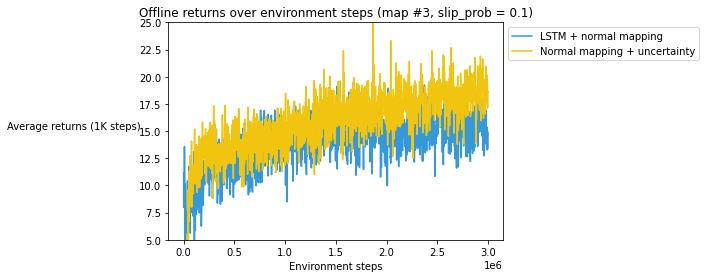

In [54]:
# with slip
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(5, 25)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (map #3, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [39]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [225]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=100)


In [236]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf4m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=5),
  13.888266666666667,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/b3e80faed60c4d2fc0f50a710bf02b5a_Sun May  8 20:17:52 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/7d918d250ee157f979d737dd5c372a96_Sun May  8 20:17:52 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/5dc5efcaa4f075482c33ee048731be38_Sun May  8 20:22:50 2022.npy')]),
 'uf4m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=1),
  12.8548,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/2143954cfc7726c9f0f18f4866ee888c_Sun May  8 19:41:45 2022.npy')]),
 'uf4m_cnn_lstm_trunc_10': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=10),
  14.0445333333

In [237]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


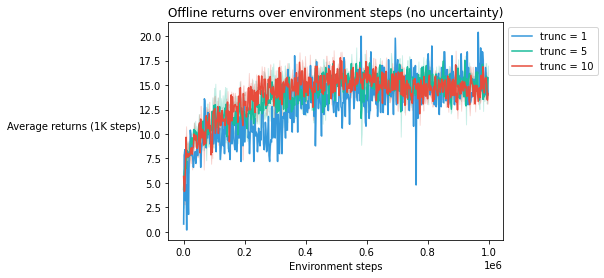

In [255]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/tmp/ipykernel_28830/250011256.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/tmp/ipykernel_28830/250011256.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/tmp/ipykernel_28830/250011256.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


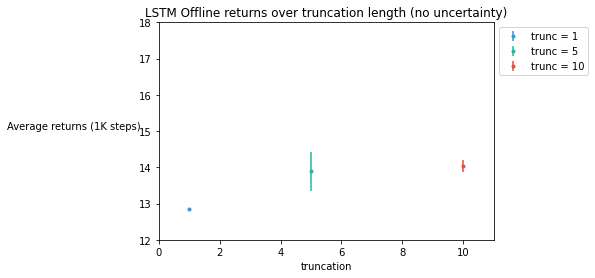

In [254]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
ax.set_xlim(0, 11)
ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

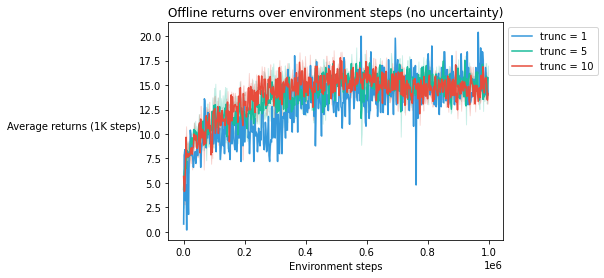

In [245]:
plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [246]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf4m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=0.9, slip_prob=0.1, trunc=5),
  16.214133333333333,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/e199d5e6d2a1b19bd0e6a89f7dcdd0c5_Sun May  8 20:32:51 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/d26266b2b4e963339bf239d33315d009_Sun May  8 20:38:15 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/61f36ebc76feb9f7e1372ff66b9cc7d6_Sun May  8 20:32:51 2022.npy')]),
 'uf4m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=0.99, slip_prob=0.1, trunc=1),
  15.601866666666668,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/3adb336a39b8d16908cbfbccac6e2937_Sun May  8 19:51:34 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn_lstm/967f5ce8419e0401d36decde686aaeb9_Sun May  8 19:41:45 2022.npy'),
   Po

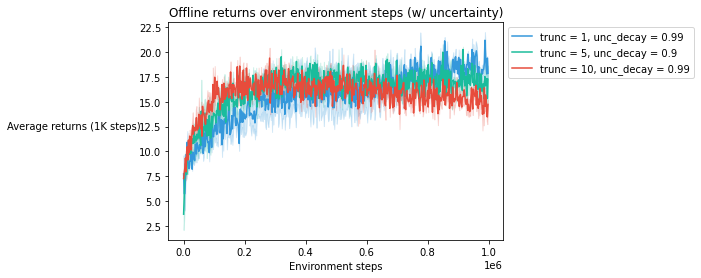

In [247]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1, unc_decay = 0.99'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5, unc_decay = 0.9'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10, unc_decay = 0.99'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [16.8032 16.9632 13.0392]
k: 5, step_means: [15.5192 16.0004 17.1228]
k: 10, step_means: [15.4388 15.76   15.9504]


/tmp/ipykernel_28830/422856948.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/tmp/ipykernel_28830/422856948.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/tmp/ipykernel_28830/422856948.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


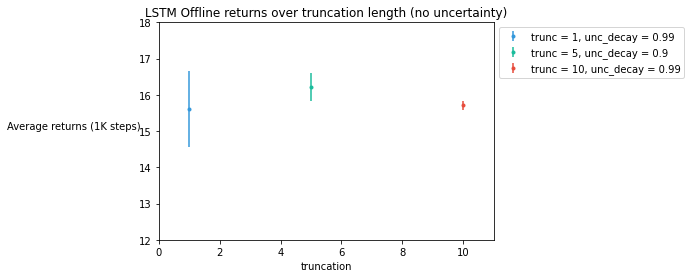

In [252]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
ax.set_xlim(0, 11)
ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')